# Autocorrelation Systematics Sampler

Example notebook for the sampling of systematics in an autocorrelation visibility, where reflections
are the focus, though coupling systematics is sampled for as well as its power may not be negligible depending on the noise level. Reflection mitigation in a cross-correlation is done here, but more useful coupling sampling is done in Cross_Correlation_Sampler.

To do: Can probably split sampler and recovery into separate notebooks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import arviz as az

import pymc3 as pm

import theano.tensor as T

from scipy.signal import windows
from numpy.fft import fft, fftshift, ifftshift
from astropy import units

from Delay_Transform import gen_window
from Delay_Transform import fourier_freqs
from Delay_Transform import FFT

from Systematics_Functions import Auto_Systematics, Auto_Systematics_No_T, Auto_Subtract

In [2]:
def Fourier_Transform(freqs,data,freq_taper):

    plot_units = {
        "lst": "hour",
        "time": "day",
        "freq": "MHz",
        "fringe-rate": "mHz",
        "delay": "ns"
    }
    

    scale_factor = 1 # Get FFT data units right.
    
    scale_factor *= np.mean(np.diff(freqs)) # Hz
    delays = fourier_freqs(freqs) * units.s.to(plot_units["delay"])
    data = np.atleast_2d(data)
    data = FFT(data, axis=1, taper=freq_taper)

    
    #Delay Space
    data *= scale_factor
    
    return([delays,data])

In [3]:
'''Power spectrum plotter'''

def Delay_Plot(FT_Data, label, color, linestyle):
    plt.plot(FT_Data[0], np.abs(FT_Data[1][0]*np.conj(FT_Data[1][0])),
             linewidth=1.25, label=label, color=color, linestyle=linestyle)

    plt.legend(frameon=False)
    plt.yscale('log')
    plt.xlim(-500,2000)
    #plt.ylim(1e1,5e17)
    plt.xlabel('$\\tau$ [ns]',fontsize=12)
    plt.ylabel('|$\\rm{V}_{\\rm{ab}}$|$^2$($\\nu$) [Jy Hz]$^2$',fontsize=12)
    plt.tight_layout()

In [4]:
#Data to be modelled - subselect the middle 512 frequency channels (no noise inserted yet)

Data = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.1.npy')[0][75:587]
freqs = np.load("example_data/freqs.npy", allow_pickle=True)[0][75:587]

Data_FT = Fourier_Transform(freqs,Data,'blackman-harris')

## Bayesian Model

In [5]:
'''Use the autocorrelations (the data itself in this case) to form the noise estimate'''

dt = 10.73 #Integration time in seconds
freq_width = freqs[1] - freqs[0] #Frequency channel width in Hz

sigma = np.sqrt(np.abs((Data)*(Data))/(dt*freq_width))

#Form the complex noise visibility
sigma_comp = sigma*np.random.normal(loc=0.0, scale=1, size=512,)/np.sqrt(2) + 1j*sigma*np.random.normal(loc=0.0, scale=1, size=512)/np.sqrt(2)
sigma_comp_FT = Fourier_Transform(freqs,sigma_comp,'blackman-harris')

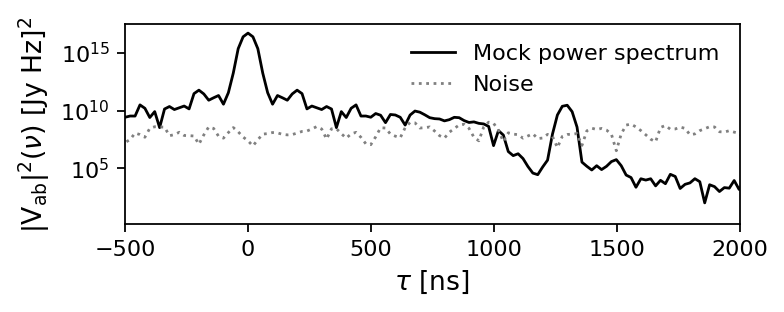

In [6]:
'''Compare the noise to the mock power spectrum'''

fig, axes = plt.subplots(figsize=(5,2),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')

In [7]:
'''Model Components'''

#Form the noisy mock data for the likelihood
Y = np.column_stack([Data.real + sigma_comp.real, Data.imag + sigma_comp.imag])

FG_Evecs = np.load('components/FG_evecs_auto.npy') #Foreground eigenvectors

EoR_FModes = np.load('components/EoR_fModes_auto.npy') #Signal Fourier modes

#Vectorise for the sampler
FG_Evecs_Split = [FG_Evecs.real, FG_Evecs.imag]
EoR_FModes_Split = [EoR_FModes.real, EoR_FModes.imag]

#Noise estimate for the sampler
sig_T = np.column_stack([np.sqrt(np.abs((Data)*(Data))/(dt*freq_width)),
                         np.sqrt(np.abs((Data)*(Data))/(dt*freq_width))])


In [8]:
'''Parameter estimates

Define the best estimates for the parameters present in the model. 
These become the prior means.'''


#High-amplitude reflections
    #Estimated by eye
refl_amp_est = np.array([5e-3,8e-4])

refl_dly_est = np.array([2e-7,12.9e-7])

#---------------------------------

#Subreflections
    #Amplitudes estimated with a power-law function (Ax^B), where
    #the amplitude and exponent were estimated and then the results compared 
    #to the data
subreflAmps_est = np.array([1.00000000e-03, 5.86977950e-04, 4.29807717e-04, 3.44543113e-04,
       2.90239439e-04, 2.52287652e-04, 2.24098647e-04, 2.02239210e-04,
       1.84734673e-04, 1.70364151e-04, 1.58329884e-04, 1.48087289e-04,
       1.39251176e-04, 1.31540964e-04, 1.24747151e-04, 1.18709957e-04,
       1.13305281e-04, 1.08435180e-04, 1.04021263e-04, 1.00000000e-04])

    #Delays estimated by eye
subreflDlys_est = np.array([1.99e-07, 2.57e-07, 3.08e-07, 3.24e-07,
        3.90e-07, 4.26e-07, 4.46e-07, 4.76e-07,
        5.25e-07, 5.869e-07, 6.24e-07, 6.61e-07,
        6.86e-07, 7.21e-07, 7.74e-07, 8.31e-07,
        8.66e-07, 9.23e-07, 9.80e-07, 1.00e-06])

#---------------------------------

#Foreground amplitudes (these amplitudes found with a vector projection)
FGAmps_est = np.array([ 2.85516024e+02,  1.51417511e+01, -2.02016444e+00,  6.83331821e+00,
        3.62511020e+00, -2.28271692e+00, -1.90805268e+00,  5.18643067e-01,
        6.31779146e-02,  3.71451503e-01,  5.98064004e-02, -9.94735693e-02,
        1.27605973e-02, -8.75879457e-02, -4.96846701e-02, -8.01324858e-02,
        3.41877266e-02, -6.69168823e-02,  6.20293215e-03, -1.04808349e-02,
        1.09651681e-02, -1.52172691e-02, -2.66249728e-02, -4.57856584e-03,
        4.01914564e-02,  1.15707165e-03,  9.81038615e-04, -1.21967552e-02,
        2.51194260e-02, -2.41115117e-03])

#---------------------------------

#Cross-coupling (Number of peaks, delays, amplitudes, delays)
    #Amplitudes estimated by assuming regular decrease in power in log-space 
cc_amps_est = np.array([ 9.97333474e-05,  6.33844172e-05,  9.07908648e-05,  2.23616641e-05,
         1.26058220e-05, 7.10027776e-06,  4.60676561e-06,  2.65407101e-06,
         2.56274059e-06, 8.97428919e-07])

    #Delays esimated by assuming even spacing across 900-1300 ns
cc_dlys_est = np.array([8.99216178e-07, 9.44489658e-07, 9.89849504e-07, 1.03511294e-06,
        1.07838627e-06, 1.12348204e-06, 1.16517194e-06, 1.21102143e-06,
        1.25594504e-06, 1.30028752e-06])

#---------------------------------

#EoR amplitudes, found by a Fourier decomposition of a model signal - already good enough, so just make amps = 1
EORAmps_est = np.ones(199)

#---------------------------------

#Define how many systematics of each type there are, and how many modes need to be
#used for the foregrounds and EoR models

NRefls = len(refl_dly_est)
cc_Ncopies = len(cc_dlys_est)
NSubrefls = len(subreflDlys_est)

#There are more modes available, so explicitly choose how many are wanted
N_EoR_Modes = 199
N_FG_Evecs = 30 


In [9]:
'''Make a plot of the estimates as a quick check'''

Estimate_Plot = Auto_Systematics_No_T(refl_amp=refl_amp_est, refl_dly=refl_dly_est, refl_phs=np.zeros(len(refl_dly_est)),
                                            cc_amps=cc_amps_est, cc_dlys=cc_dlys_est, cc_phs=np.zeros(cc_Ncopies),
                                            subreflAmps=subreflAmps_est, subreflDlys=subreflDlys_est, subreflPhses=np.zeros(NSubrefls),
                                            FGAmps=FGAmps_est, FG_Evecs=FG_Evecs_Split, EORFAmps=EORAmps_est, EOR_FModes=EoR_FModes_Split,
                                    freqs=freqs, NRefls=NRefls, cc_Ncopies=cc_Ncopies, NSubrefls=NSubrefls, N_FAmps=N_EoR_Modes, N_FGAmps=N_FG_Evecs)

Estimate_Plot_FT = Fourier_Transform(freqs, Estimate_Plot[:,0] + Estimate_Plot[:,1]*1j,'blackman-harris')

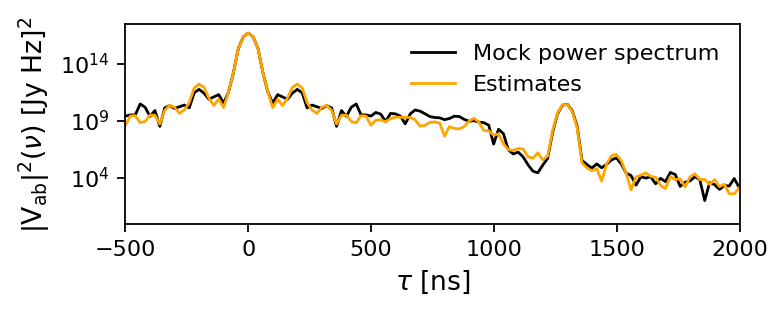

In [10]:
fig, axes = plt.subplots(figsize=(5,2),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(Estimate_Plot_FT, 'Estimates', 'orange', '-')

In [12]:
'''Model setup

    Estimates above are used for the prior means. For the most part, priors are normal distributions with
    mean zero and standard deviation one, which are rescaled to the estimates and the desired prior width.
    
    E.g. A cable reflection delay is sampled at N(0,1), and thereafter transformed with: Delay_Estimate + N(0,1) * width.
    
    This is not done for parameters with means sufficiently close to ~order(1).
    
    Prior widths are chosen relative to the means, e.g. the foreground amplitudes have widths 5% of the mean/estimate'''

with pm.Model() as model:
    
    '''Foreground Eigenvector Amplitudes'''
    FGAmps = pm.Normal('FGAmps', mu=FGAmps_est, sigma=np.abs(FGAmps_est)*0.05, shape=N_FG_Evecs)
    
    '''EOR Fourier Mode Amps'''
    EORFAmps = pm.Normal('EORFAmps', mu=EORAmps_est, sigma=EORAmps_est*5, shape=N_EoR_Modes) 
    
    '''Cable Reflections'''
    refl_amp = pm.Normal("refl_amp", mu=0, sigma=1, shape=len(refl_amp_est))
    refl_amp_scaled = pm.Deterministic("refl_amp_scaled", refl_amp_est + [0.05e-3,0.05e-4]*refl_amp) #0.1
    
    refl_dly = pm.Normal("refl_dly", mu=0, sigma=1, shape=len(refl_dly_est))
    refl_dly_scaled = pm.Deterministic("refl_dly_scaled", refl_dly_est + 0.05e-7*refl_dly)

    
    refl_phs = pm.Normal("refl_phs", mu=0, sigma=1, shape=len(refl_dly_est))
    
    
    '''Cross-coupling'''
    cc_dlys = pm.Normal("cc_dlys", mu=0, sigma=1, shape=cc_Ncopies)
    cc_dlys_scaled = pm.Deterministic("cc_dlys_scaled", cc_dlys_est + cc_dlys*1e-9)
    
    cc_amps = pm.Normal("cc_amps", mu=0, sigma=0.1, shape=cc_Ncopies)
    
    cc_amps_scaled = pm.Deterministic("cc_amps_scaled", cc_amps_est + 
                                      cc_amps*np.array([1e-04, 1e-05, 1e-05, 1e-05,1e-05, 1e-06, 1e-06, 1e-06,1e-06, 1e-06]))
    
    cc_phs = pm.Normal("cc_phs", mu=0, sigma=1, shape=cc_Ncopies)
    
    '''Subreflections'''
    
    subreflAmps = pm.Normal("subreflAmps", mu=0, sigma=1, shape=NSubrefls)
    subreflAmps_scaled = pm.Deterministic("subreflAmps_scaled", subreflAmps_est + subreflAmps*1e-4) #1e-4
    
    subreflDlys = pm.Normal("subreflDlys", mu=0, sigma=1, shape=NSubrefls)
    subreflDlys_scaled = pm.Deterministic("subreflDlys_scaled", subreflDlys_est + subreflDlys*1e-9) #1e-9
    
    subreflPhses = pm.Normal("subreflPhses", mu=0, sigma=1, shape=NSubrefls)
    

    #observed is the mock data
    Y_Obs = pm.Normal("obs", mu=Auto_Systematics(refl_amp=refl_amp_scaled,refl_dly=refl_dly_scaled,refl_phs=refl_phs,
                                            cc_amps=cc_amps_scaled, cc_dlys=cc_dlys_scaled, cc_phs=cc_phs,
                                            subreflAmps=subreflAmps_scaled, subreflDlys=subreflDlys_scaled, subreflPhses=subreflPhses,
                                            FGAmps=FGAmps,FG_Evecs=FG_Evecs_Split,EORFAmps=EORFAmps,EOR_FModes=EoR_FModes_Split,
                                    freqs=freqs, NRefls=NRefls, cc_Ncopies=cc_Ncopies, NSubrefls=NSubrefls,N_FAmps=N_EoR_Modes,
                                                 N_FGAmps=N_FG_Evecs),
                        observed=Y,sigma=sig_T)

In [51]:
'''Sampler setup and run

    - >1 chain for diagnostics purposes
    - advi initialiser for (generally) best performance
    - arbitrarily large number of initialisation steps to ensure convergence
    - use more tuning steps for lower noise cases (to help prevent divergences in the sampling), or
        for better results overall - more tuning generally results in better model estimates
    - increase number of draws for better stats
    - increase target accept above 0.8 (default) if there are divergences (but slows the sampler)'''

with model:
    trace = pm.sample(
        chains=2,
        cores=2,
        init='advi',
        n_init=1000000,
        draws=5000,
        tune=4000,
        target_accept=0.9,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 63100
Interrupted at 63,099 [6%]: Average Loss = 9.5693e+06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [subreflPhses, subreflDlys, subreflAmps, cc_phs, cc_amps, cc_dlys, refl_phs, refl_dly, refl_amp, EORFAmps, FGAmps]


Sampling 2 chains for 4_000 tune and 5_000 draw iterations (8_000 + 10_000 draws total) took 4050 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [52]:
'''Save the trace'''
#trace.to_netcdf("traces/1_1_trace_single_integration.nc")

'traces/1_1_trace_single_integration.nc'

## Comparison and Recovery

### Autocorrelation Recovery

In [12]:
'''Load a trace'''
#trace = az.from_netcdf("traces/1_1_trace_single_integration.nc")

In [13]:
'''Combine however many chains have been used in sampling'''

N_chains = np.shape(trace.posterior['refl_amp_scaled'])[0]
N_samples = np.shape(trace.posterior['refl_amp_scaled'])[1]


refl_amp_results = np.array(trace.posterior['refl_amp_scaled']).reshape(N_chains*N_samples, NRefls)

refl_dly_results = np.array(trace.posterior['refl_dly_scaled']).reshape(N_chains*N_samples, NRefls)

refl_phs_results = np.array(trace.posterior['refl_phs']).reshape(N_chains*N_samples, NRefls)

cc_amps_results = np.array(trace.posterior['cc_amps_scaled']).reshape(N_chains*N_samples, cc_Ncopies)

cc_dlys_results = np.array(trace.posterior['cc_dlys_scaled']).reshape(N_chains*N_samples, cc_Ncopies)

cc_phs_results = np.array(trace.posterior['cc_phs']).reshape(N_chains*N_samples, cc_Ncopies)

subreflAmps_results = np.array(trace.posterior['subreflAmps_scaled']).reshape(N_chains*N_samples, NSubrefls)

subreflDlys_results = np.array(trace.posterior['subreflDlys_scaled']).reshape(N_chains*N_samples, NSubrefls)

subreflPhses_results = np.array(trace.posterior['subreflPhses']).reshape(N_chains*N_samples, NSubrefls)

FGAmp_results = np.array(trace.posterior['FGAmps']).reshape(N_chains*N_samples, N_FG_Evecs)

EORFAmps_results = np.array(trace.posterior['EORFAmps']).reshape(N_chains*N_samples, N_EoR_Modes)

In [14]:
'''Form an array containing visibilities corresponding to all samples, i.e. one step
    in the chain becomes one visibility'''

Model_Results_All = []

for qq in range(0,N_chains*N_samples):
    
    #Print some sort of progress
    if qq % 1000 == 0:
            print(str(qq) + '/' + str(N_chains*N_samples),end=' ')
    
    Model_Results = Auto_Systematics_No_T(refl_amp=refl_amp_results[qq], refl_dly=refl_dly_results[qq],
                           refl_phs=refl_phs_results[qq],
                                        cc_amps=cc_amps_results[qq], cc_dlys=cc_dlys_results[qq], 
                                    cc_phs=cc_phs_results[qq],
                           subreflAmps=subreflAmps_results[qq], subreflDlys=subreflDlys_results[qq], 
                           subreflPhses=subreflPhses_results[qq],
                           FGAmps=FGAmp_results[qq], FG_Evecs=FG_Evecs_Split,
                           EORFAmps=EORFAmps_results[qq], EOR_FModes=EoR_FModes_Split,
                    freqs=freqs, NRefls=NRefls, cc_Ncopies=cc_Ncopies, NSubrefls=NSubrefls, N_FAmps=N_EoR_Modes, N_FGAmps=N_FG_Evecs)
    
    Model_Results_complex = Model_Results[:,0] + Model_Results[:,1]*1j
    
    Model_Results_FT = Fourier_Transform(freqs,Model_Results_complex,'blackman-harris')

    
    Model_Results_All.append(Model_Results_FT[1][0])
    
Model_Results_All = np.array(Model_Results_All)

0/10000 1000/10000 2000/10000 3000/10000 4000/10000 5000/10000 6000/10000 7000/10000 8000/10000 9000/10000 

In [15]:
'''Find the 95th percentile of the model visibilities'''

mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Model_Results_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Model_Results_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Model_Results_All.T[vv]), 5, axis=0))

In [16]:
#Load the data with only bandpass gains applied. This method makes no assumption on whether gains are in the data or not,
# but including them helps with comparison. 
Data_Gains = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.1.GAINS.npy')[0][75:587]
Data_Gains_FT = Fourier_Transform(freqs,Data_Gains,'blackman-harris')

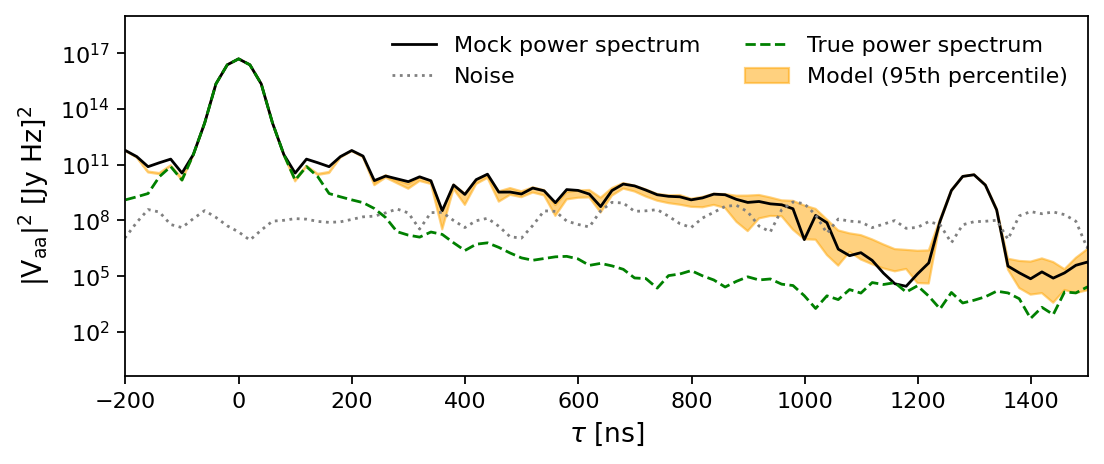

In [17]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')
Delay_Plot(Data_Gains_FT, 'True power spectrum', 'green', '--')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(perc_95*np.conj(perc_95)),
                    color='orange',linewidth=1,alpha=0.5,label='Model (95th percentile)')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(4e-1,1e19)
#plt.axvline(940)
plt.legend(frameon=False,ncol=2)

plt.ylabel('|V$_{\\rm{aa}}$|$^2$ [Jy Hz]$^2$',fontsize=12)

plt.xlabel('$\\tau$ [ns]',fontsize=12)
fig.tight_layout()


In [18]:
'''Form recovered visibilities for all samples'''

Sample_Recovered_All = []

for dd in range(0,N_chains*N_samples):
    
    if dd % 1000 == 0:
            print(str(dd) + '/' + str(N_chains*N_samples),end=' ')

    Sample_Recovered = Auto_Subtract(Obs=Y,refl_amp=refl_amp_results[dd],refl_dly=refl_dly_results[dd],
                               refl_phs=refl_phs_results[dd],
                                            cc_amps=cc_amps_results[dd], cc_dlys=cc_dlys_results[dd], 
                                        cc_phs=cc_phs_results[dd],
                               subreflAmps=subreflAmps_results[dd], subreflDlys=subreflDlys_results[dd], 
                               subreflPhses=subreflPhses_results[dd],
                               FGAmps=FGAmp_results[dd], FG_Evecs=FG_Evecs_Split,
                           EORFAmps=EORFAmps_results[dd], EOR_FModes=EoR_FModes_Split,
                    freqs=freqs, NRefls=NRefls, cc_Ncopies=cc_Ncopies, NSubrefls=NSubrefls, N_FAmps=N_EoR_Modes, N_FGAmps=N_FG_Evecs)

    
    Sample_Recovered_complex = Sample_Recovered[:,0] + Sample_Recovered[:,1]*1j
    
    Sample_Recovered_complex_FT = Fourier_Transform(freqs,Sample_Recovered_complex,'blackman-harris')
    #Residual_FT = Fourier_Transform(freqs,SysCheck_Residual,'blackman-harris')
    
    Sample_Recovered_All.append(Sample_Recovered_complex_FT[1][0])
    
Sample_Recovered_All = np.array(Sample_Recovered_All)

0/10000 1000/10000 2000/10000 3000/10000 4000/10000 5000/10000 6000/10000 7000/10000 8000/10000 9000/10000 

In [19]:
mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Sample_Recovered_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Sample_Recovered_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Sample_Recovered_All.T[vv]), 5, axis=0))

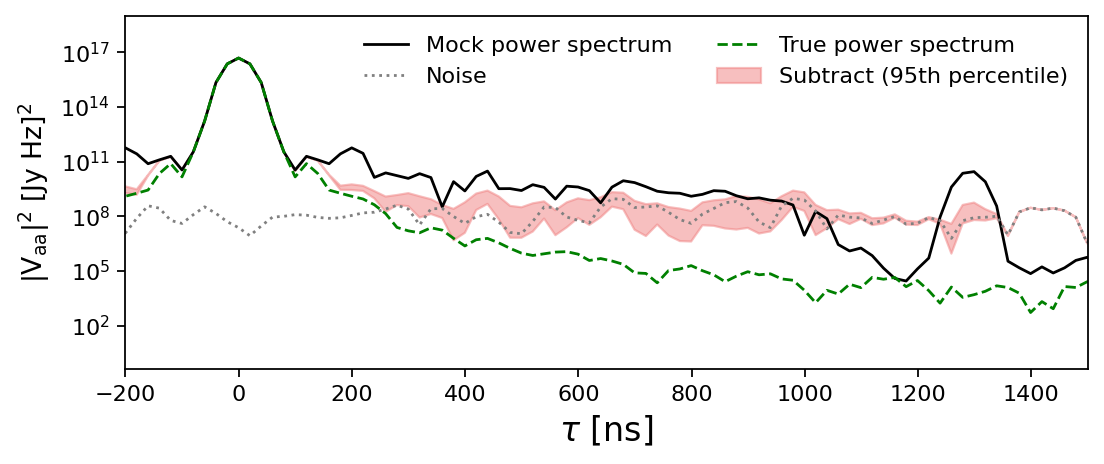

In [20]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)


Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')
Delay_Plot(Data_Gains_FT, 'True power spectrum', 'green', '--')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(perc_95*np.conj(perc_95)),color='lightcoral',
                 linewidth=1,alpha=0.5,label='Subtract (95th percentile)')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(4e-1,1e19)
#plt.axvline(940)
plt.legend(frameon=False,ncol=2)

plt.ylabel('|V$_{\\rm{aa}}$|$^2$ [Jy Hz]$^2$',fontsize=12)
plt.xlabel('$\\tau$ [ns]',fontsize=15)

fig.tight_layout()

### Cross-correlation Recovery

Mitigate the reflections in the corresponding cross-correlation. Note that this is not completely correct for this example. The autocorrelations were modelled in the high-noise regime, while we ignore the noise in the cross-correlation below. 

There is not much to be gained from mitigating reflections in the high-noise cross-correlation, since the noise is so strong (|V$_{12}$|$^2 \sim 10^8$ Jy$^2$Hz$^2$) relative to the reflections. Instead, the below example simply neglects the noise, and applies the reflection calibration using the results above. 

However, the process is the same for the general low-noise case, i.e. where the autocorrelations have negligible noise as well. 

Note that the sampling for the essentially noise-free case takes very long.

In [21]:
#The cross-correlation corresponding to the antenna modelled above, which only contains reflections. Load the visibility 
#with only gains applied, as well.
Data_Cross = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.2.REFL.npy')[0][75:587]
Data_Cross_Gains = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.2.GAINS.npy')[0][75:587]

Y_Cross = np.column_stack([Data_Cross.real, Data_Cross.imag])

Data_Cross_FT = Fourier_Transform(freqs,Data_Cross,'blackman-harris')
Data_Cross_Gains_FT = Fourier_Transform(freqs,Data_Cross_Gains,'blackman-harris')

In [22]:
'''Form recovered visibilities for all samples
    Note that cross-correlation mitigation is ignored here, as it's 
    modelled in the cross-correlations themselves.'''

Cross_Recovered_All = []

for dd in range(0,N_chains*N_samples):
    
    if dd % 1000 == 0:
            print(str(dd) + '/' + str(N_chains*N_samples),end=' ')

    Cross_Recovered = Auto_Subtract(Obs=Y_Cross,refl_amp=refl_amp_results[dd],refl_dly=refl_dly_results[dd],
                               refl_phs=refl_phs_results[dd],
                                            cc_amps=cc_amps_results[dd]*0, cc_dlys=cc_dlys_results[dd], 
                                        cc_phs=cc_phs_results[dd],
                               subreflAmps=subreflAmps_results[dd], subreflDlys=subreflDlys_results[dd], 
                               subreflPhses=subreflPhses_results[dd],
                               FGAmps=FGAmp_results[dd], FG_Evecs=FG_Evecs_Split,
                           EORFAmps=EORFAmps_results[dd], EOR_FModes=EoR_FModes_Split,
                    freqs=freqs, NRefls=NRefls, cc_Ncopies=cc_Ncopies, NSubrefls=NSubrefls, N_FAmps=N_EoR_Modes, N_FGAmps=N_FG_Evecs)

    
    Cross_Recovered_complex = Cross_Recovered[:,0] + Cross_Recovered[:,1]*1j
    
    Cross_Recovered_complex_FT = Fourier_Transform(freqs,Cross_Recovered_complex,'blackman-harris')
    #Residual_FT = Fourier_Transform(freqs,SysCheck_Residual,'blackman-harris')
    
    Cross_Recovered_All.append(Cross_Recovered_complex_FT[1][0])
    
Cross_Recovered_All = np.array(Cross_Recovered_All)

0/10000 1000/10000 2000/10000 3000/10000 4000/10000 5000/10000 6000/10000 7000/10000 8000/10000 9000/10000 

In [23]:
mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Cross_Recovered_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Cross_Recovered_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Cross_Recovered_All.T[vv]), 5, axis=0))

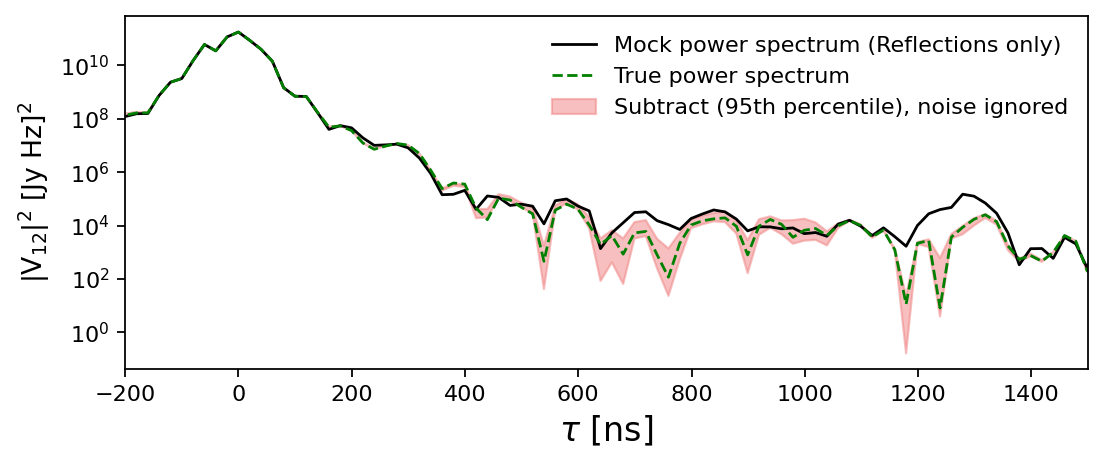

In [24]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)


Delay_Plot(Data_Cross_FT, 'Mock power spectrum (Reflections only)', 'k', '-')
#Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')
Delay_Plot(Data_Cross_Gains_FT, 'True power spectrum', 'green', '--')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(perc_95*np.conj(perc_95)),color='lightcoral',
                 linewidth=1,alpha=0.5,label='Subtract (95th percentile), noise ignored')

plt.yscale('log')
plt.xlim(-200,1500)
#plt.ylim(4e-1,1e19)
#plt.axvline(940)
plt.legend(frameon=False)

plt.ylabel('|V$_{\\rm{12}}$|$^2$ [Jy Hz]$^2$',fontsize=12)
plt.xlabel('$\\tau$ [ns]',fontsize=15)

fig.tight_layout()

## Signal Loss

An example of signal loss calculations for the cross-correlation, defined as $R_3 = \frac{<P_{Recovered}>}{<P_{True}>}$, i.e. the ratio of the time-averaged recovered power spectra to the time-averaged true spectra. 

Again, this implementation is not fully correct, as the reflections were modelled on noisy autocorrelations, and model results are being applied to noise-free cross-correlations. However, the process is the same should the noise be reduced in the autocorrelations.

In [25]:
Data_Cross_Full = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.2.REFL.npy')[:,75:587]
Data_Cross_Full_Gains = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.2.GAINS.npy')[:,75:587]

Data_Cross_Full_Gains_FT = Fourier_Transform(freqs,Data_Cross_Full_Gains,'blackman-harris')

To do: this takes a lot of memory - optimise

In [26]:
Data_Sys_Subbed = []

N_times = np.shape(Data_Cross_Full)[0]

#Loop through all times in the full data set
for pp in range(0,N_times):
    
    print(str(pp) + '/' + str(N_times),end=' ')
    
    Single_t_result = [] #The recovery result for the currently selected time
    
    Y_Cross_t = np.column_stack([Data_Cross_Full[pp].real, Data_Cross_Full[pp].imag])
    
    #Find the recovery result for all samples when applied to the visibility at this particular time
    for dd in range(0,N_chains*N_samples):

        '''ss_Subtract = Subtract_Cross(Obs=Y_Cross_t,refl_amp=refl_amp_results[dd],refl_dly=refl_dly_results[dd],
                                   refl_phs=refl_phs_results[dd],
                                                cc_amps=cc_amps_results[dd], cc_dlys=cc_dlys_results[dd], 
                                            cc_phs=cc_phs_results[dd],
                                   subreflAmps=subreflAmps_results[dd], subreflDlys=subreflDlys_results[dd], 
                                   subreflPhses=subreflPhses_results[dd],
                        freqs=freqs, cc_Ncopies=10, NSubrefls=20,autovis=Data_Sys_All[pp][75:587])'''
        
        Cross_Subtract = Auto_Subtract(Obs=Y_Cross,refl_amp=refl_amp_results[dd],refl_dly=refl_dly_results[dd],
                               refl_phs=refl_phs_results[dd],
                                            cc_amps=cc_amps_results[dd]*0, cc_dlys=cc_dlys_results[dd], 
                                        cc_phs=cc_phs_results[dd],
                               subreflAmps=subreflAmps_results[dd], subreflDlys=subreflDlys_results[dd], 
                               subreflPhses=subreflPhses_results[dd],
                               FGAmps=FGAmp_results[dd], FG_Evecs=FG_Evecs_Split,
                           EORFAmps=EORFAmps_results[dd], EOR_FModes=EoR_FModes_Split,
                    freqs=freqs, NRefls=NRefls, cc_Ncopies=cc_Ncopies, NSubrefls=NSubrefls, N_FAmps=N_EoR_Modes, N_FGAmps=N_FG_Evecs)

        #Data_Sys_Subbed.append(Subtract_complex)
        
        Subtract_FT = Fourier_Transform(freqs,Cross_Subtract[:,0] + Cross_Subtract[:,1]*1j,'blackman-harris')
        
        Single_t_result.append(Subtract_FT[1][0]*np.conj(Subtract_FT[1][0]))
        
    Data_Sys_Subbed.append(Single_t_result)
    
    
Data_Sys_Subbed = np.array(Data_Sys_Subbed)

0/60 1/60 2/60 3/60 4/60 5/60 6/60 7/60 8/60 9/60 10/60 11/60 12/60 13/60 14/60 15/60 16/60 17/60 18/60 19/60 20/60 21/60 22/60 23/60 24/60 25/60 26/60 27/60 28/60 29/60 30/60 31/60 32/60 33/60 34/60 35/60 36/60 37/60 38/60 39/60 40/60 41/60 42/60 43/60 44/60 45/60 46/60 47/60 48/60 49/60 50/60 51/60 52/60 53/60 54/60 55/60 56/60 57/60 58/60 59/60 

In [27]:
#Form the power spectra for the true data

PS_True_Cross_FT = []
    
for xx in range(0,N_times):
    PS_True_Cross_FT.append(Data_Cross_Full_Gains_FT[1][xx]*np.conj(Data_Cross_Full_Gains_FT[1][xx]))

In [36]:
#Find the time-averaged spectra for the true and recovered power spectra
Cross_True_Av = np.mean(PS_True_Cross_FT,axis=0)
Cross_Sub_Av = np.mean(Data_Sys_Subbed,axis=0)

#Find R_3
R3_Cross = Cross_Sub_Av/Cross_True_Av

In [37]:
#Find the 95th percentile

mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(R3_Cross.T[vv])))
    perc_95.append(np.percentile(np.abs(R3_Cross.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(R3_Cross.T[vv]), 5, axis=0))

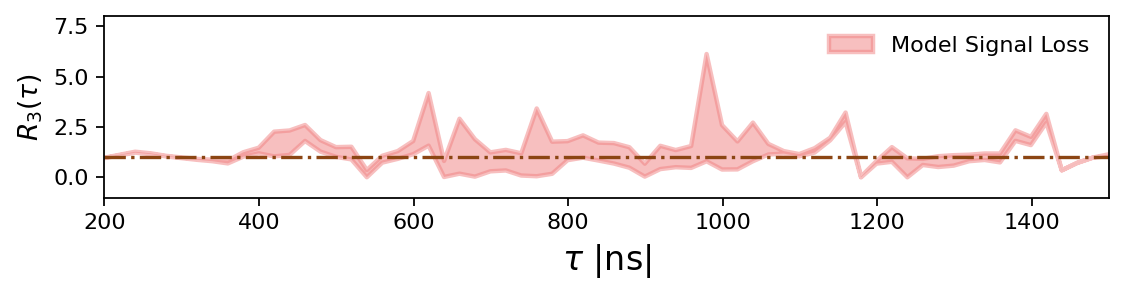

In [38]:
fig, axes = plt.subplots(figsize=(7,2),dpi=160)

plt.fill_between(Data_Cross_Full_Gains_FT[0],np.abs(perc_5),np.abs(perc_95),color='lightcoral',linewidth=2,alpha=0.5,label='Model Signal Loss')

plt.xlim(200,1500)

plt.axhline(1,color='saddlebrown',linestyle='-.')

plt.legend(frameon=False)

plt.ylim(-1,8)

plt.xlabel('$\\tau$ |ns|',fontsize=15)
plt.ylabel('$R_3({\\tau})$',fontsize=12)

plt.tight_layout()
